#### Preparación de Datos

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np


In [43]:
colors = ['crimson', 'tomato', 'darkturquoise', 'palegreen', 'gold', 'dodgerblue', 'violet', 'cornflowerblue', 'mediumvioletred']

# Cargamos el Dataset
df_list = []
for i in range(0,4):
    filename = './playlists_data/playlist' + str(i) + '.json'
    df_list.append(pd.read_json(filename))

songs = pd.concat(df_list)
songs = songs.reset_index()
songs.head()


# Eliminamos las columnas repetidas
songs = songs.drop_duplicates()
songs = songs.drop('index', axis=1)
songs = songs.drop(['id', 'title'], axis=1)
songs.head()

# Renombramos columnas para manipularlas
df = songs.rename(columns={ 'Unnamed: 0': 'track index', 'uri': 'track uri', 'labels': 'mood'})

# Creamos una nueva columna que contiene la duracion la cancion en minutos y segundos para poder interpretarla de mejor manera, sin embargo seguiremos utilizando los ms para el analisis de los datos
df['duration (mm:ss)'] = pd.to_timedelta(df['duration_ms'], unit='ms')
# utilizamos una funcion lambda para que la duracion solo muestre minutos y segundos
df['duration (mm:ss)'] = df['duration (mm:ss)'].apply(lambda x: f'{int(x.total_seconds() // 60):02d}:{int(x.total_seconds() % 60):02d}')
# utilizamos la funcion lambda para indicar que mood representa el estado de animo de la cancion

# Hacemos un diccionario para mapear los estados de animo a valores numericos
emotions_mapping = {'sad': 0, 'happy': 1, 'energetic': 2, 'calm': 3}
# Invertimos el mapeo para poder interpretar los datos
inverted_emotions_mapping = {v: k for k, v in emotions_mapping.items()}
# Mapeamos los estados de animo a valores numericos
df['class'] = df['class'].map(inverted_emotions_mapping)

# indicamos el indice de la cancion
df.reset_index(drop=True, inplace=True)
df.index.name = 'track index'

display(df)

# Para hacer los graficos necesitamos limitar a 1000 los datos
df_graphics = df.head(1000)

# Hacemos un subset para cada mood
sad = df[df['class'] == 'sad']
happy = df[df['class'] == 'happy']
energetic = df[df['class'] == 'energetic']
calm = df[df['class'] == 'calm']

print(f"Sad songs {sad.value_counts().sum()}")
print(f"Happy songs {happy.value_counts().sum()}")
print(f"Energetic songs {energetic.value_counts().sum()}")
print(f"Calm songs {calm.value_counts().sum()}")

danceability  energy  key  loudness  mode  acousticness  \
track index                                                            
0                   0.567  0.4150    3   -11.901     0         0.972   
1                   0.580  0.0545    9   -14.594     0         0.963   
2                   0.505  0.2710    5   -12.817     1         0.926   
3                   0.387  0.1180    6   -18.815     1         0.964   
4                   0.493  0.0381    3   -21.377     1         0.978   
...                   ...     ...  ...       ...   ...           ...   
194                 0.582  0.3730   11   -12.192     1         0.901   
195                 0.520  0.2120    2   -13.693     1         0.901   
196                 0.293  0.1310    2   -18.658     1         0.886   
197                 0.303  0.1870    2   -16.757     1         0.989   
198                 0.301  0.3060    7   -14.091     1         0.900   

             instrumentalness  liveness  valence    tempo  duration_ms  \
track index                                                              
0                    0.885000    0.0999   0.2730  118.967       154863   
1                    0.000265    0.0967   0.1770  123.341       149827   
2                    0.866000    0.1050   0.2030   98.630       661773   
3                    0.906000    0.1340   0.2060   73.567       209739   
4                    0.860000    0.1530   0.2490   59.621       397667   
...                       ...       ...      ...      ...          ...   
194                  0.151000    0.1040   0.4620  135.954       214867   
195                  0.000000    0.1340   0.4000   92.444       180000   
196                  0.140000    0.1050   0.1230   78.885       294189   
197                  0.499000    0.1020   0.2120  132.679       160853   
198                  0.891000    0.0831   0.0644  115.013       275022   

             time_signature  num_bars  num_sections  num_segments  class  \
track index                                                                
0                         4        73             8           537  happy   
1                         4        74             9           346  happy   
2                         4       271            31          2091  happy   
3                         4        74            10           629  happy   
4                         4        97            15          1051  happy   
...                     ...       ...           ...           ...    ...   
194                       4       121             8           811  happy   
195                       4        69             9           557  happy   
196                       4       118            11           965  happy   
197                       4        88             7           435  happy   
198                       3       171            10           922  happy   

            duration (mm:ss)  
track index                   
0                      02:34  
1                      02:29  
2                      11:01  
3                      03:29  
4                      06:37  
...                      ...  
194                    03:34  
195                    03:00  
196                    04:54  
197                    02:40  
198                    04:35  

[199 rows x 17 columns]

Sad songs 0
Happy songs 199
Energetic songs 0
Calm songs 0


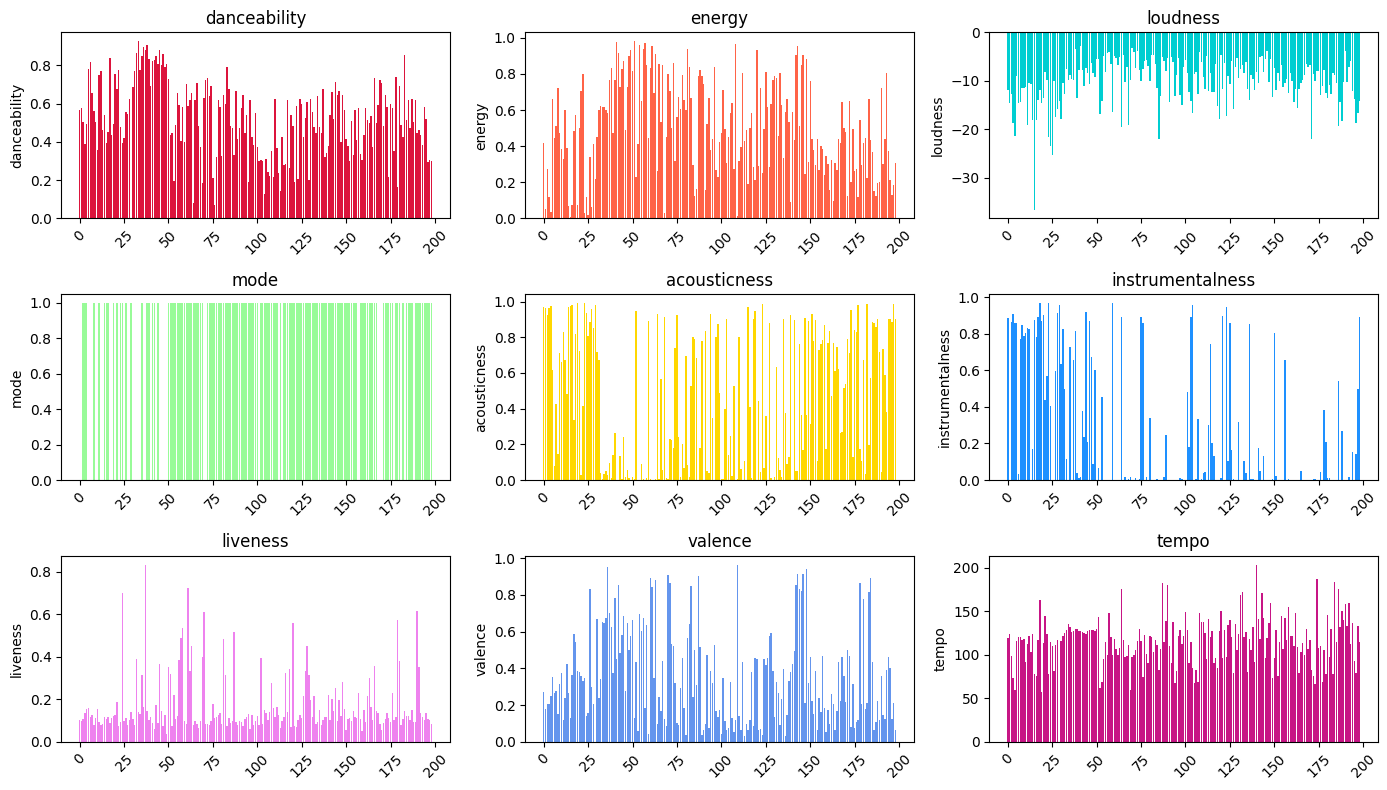

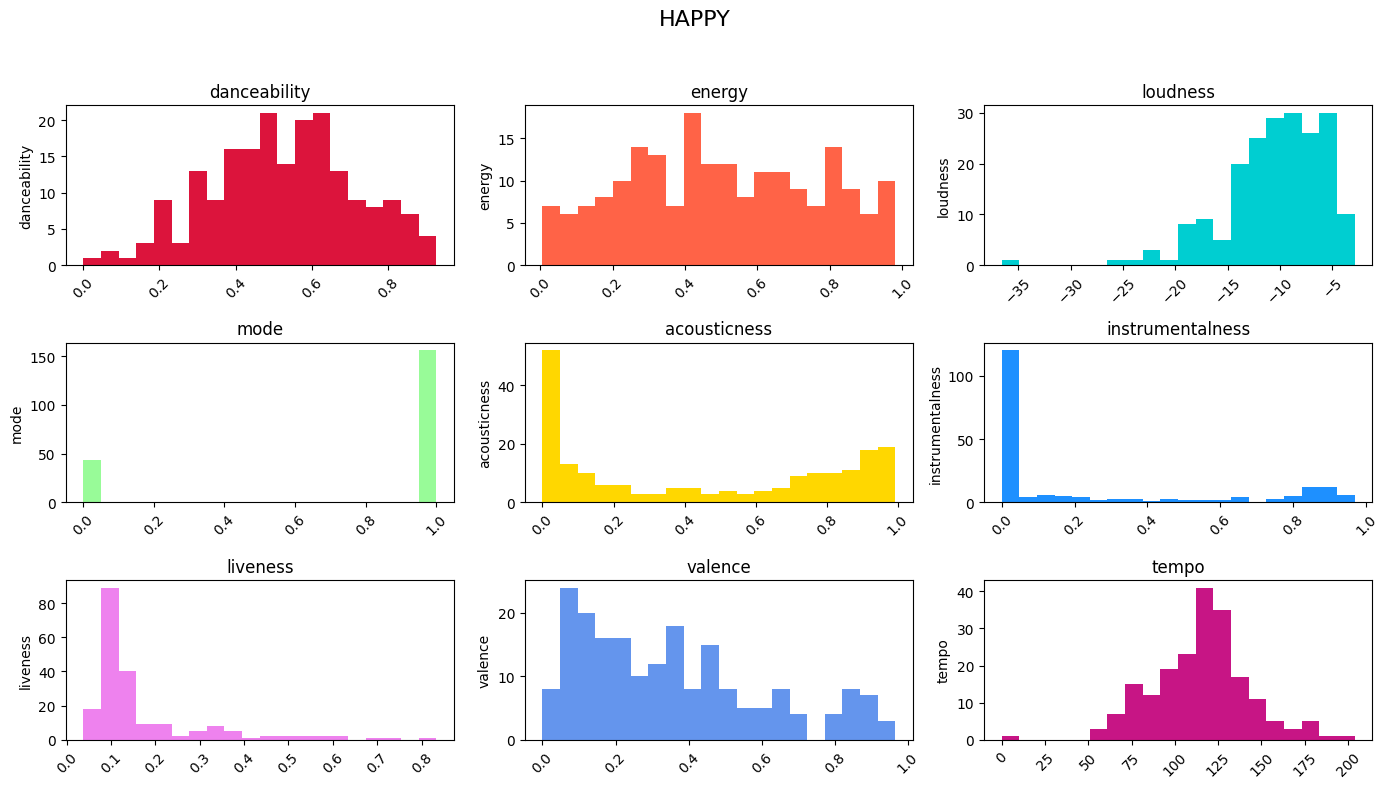

In [44]:
# Para comenzar a clasificar datos, creamos una nueva columna para catgorizar por valores de la mediana
attributes = ['danceability', 'energy', 'loudness', 'mode',
            'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

plt.figure(figsize=(14, 8))

# Creamos una grafica para cada una de las caracteristicas, limitamos el DataFrame a 1000 datos, ya que son bastantes los datos del DataFrame
for i, attribute in enumerate(attributes):
    plt.subplot(3, 3, i + 1)
    plt.bar(df_graphics.index, df_graphics[attribute], color=colors[i])
    plt.title(attribute)
    plt.ylabel(attribute)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Ahora graficamos cada una de las caracteristicas por mood en un solo grafico
for mood in df['class'].unique():
    plt.figure(figsize=(14, 8))
    for i, attribute in enumerate(attributes):
        plt.subplot(3, 3, i + 1)
        plt.hist(df[df['class'] == mood][attribute], bins=20, color=colors[i])
        plt.title(attribute)
        plt.ylabel(attribute)
        plt.xticks(rotation=45)
    
    plt.suptitle(mood.upper(), fontsize=16)  # Título principal con el valor de 'mood'
    plt.subplots_adjust(top=0.85)  # Ajusta para que no se superpongan el título y las gráficas
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Deja espacio para el título
    plt.show()


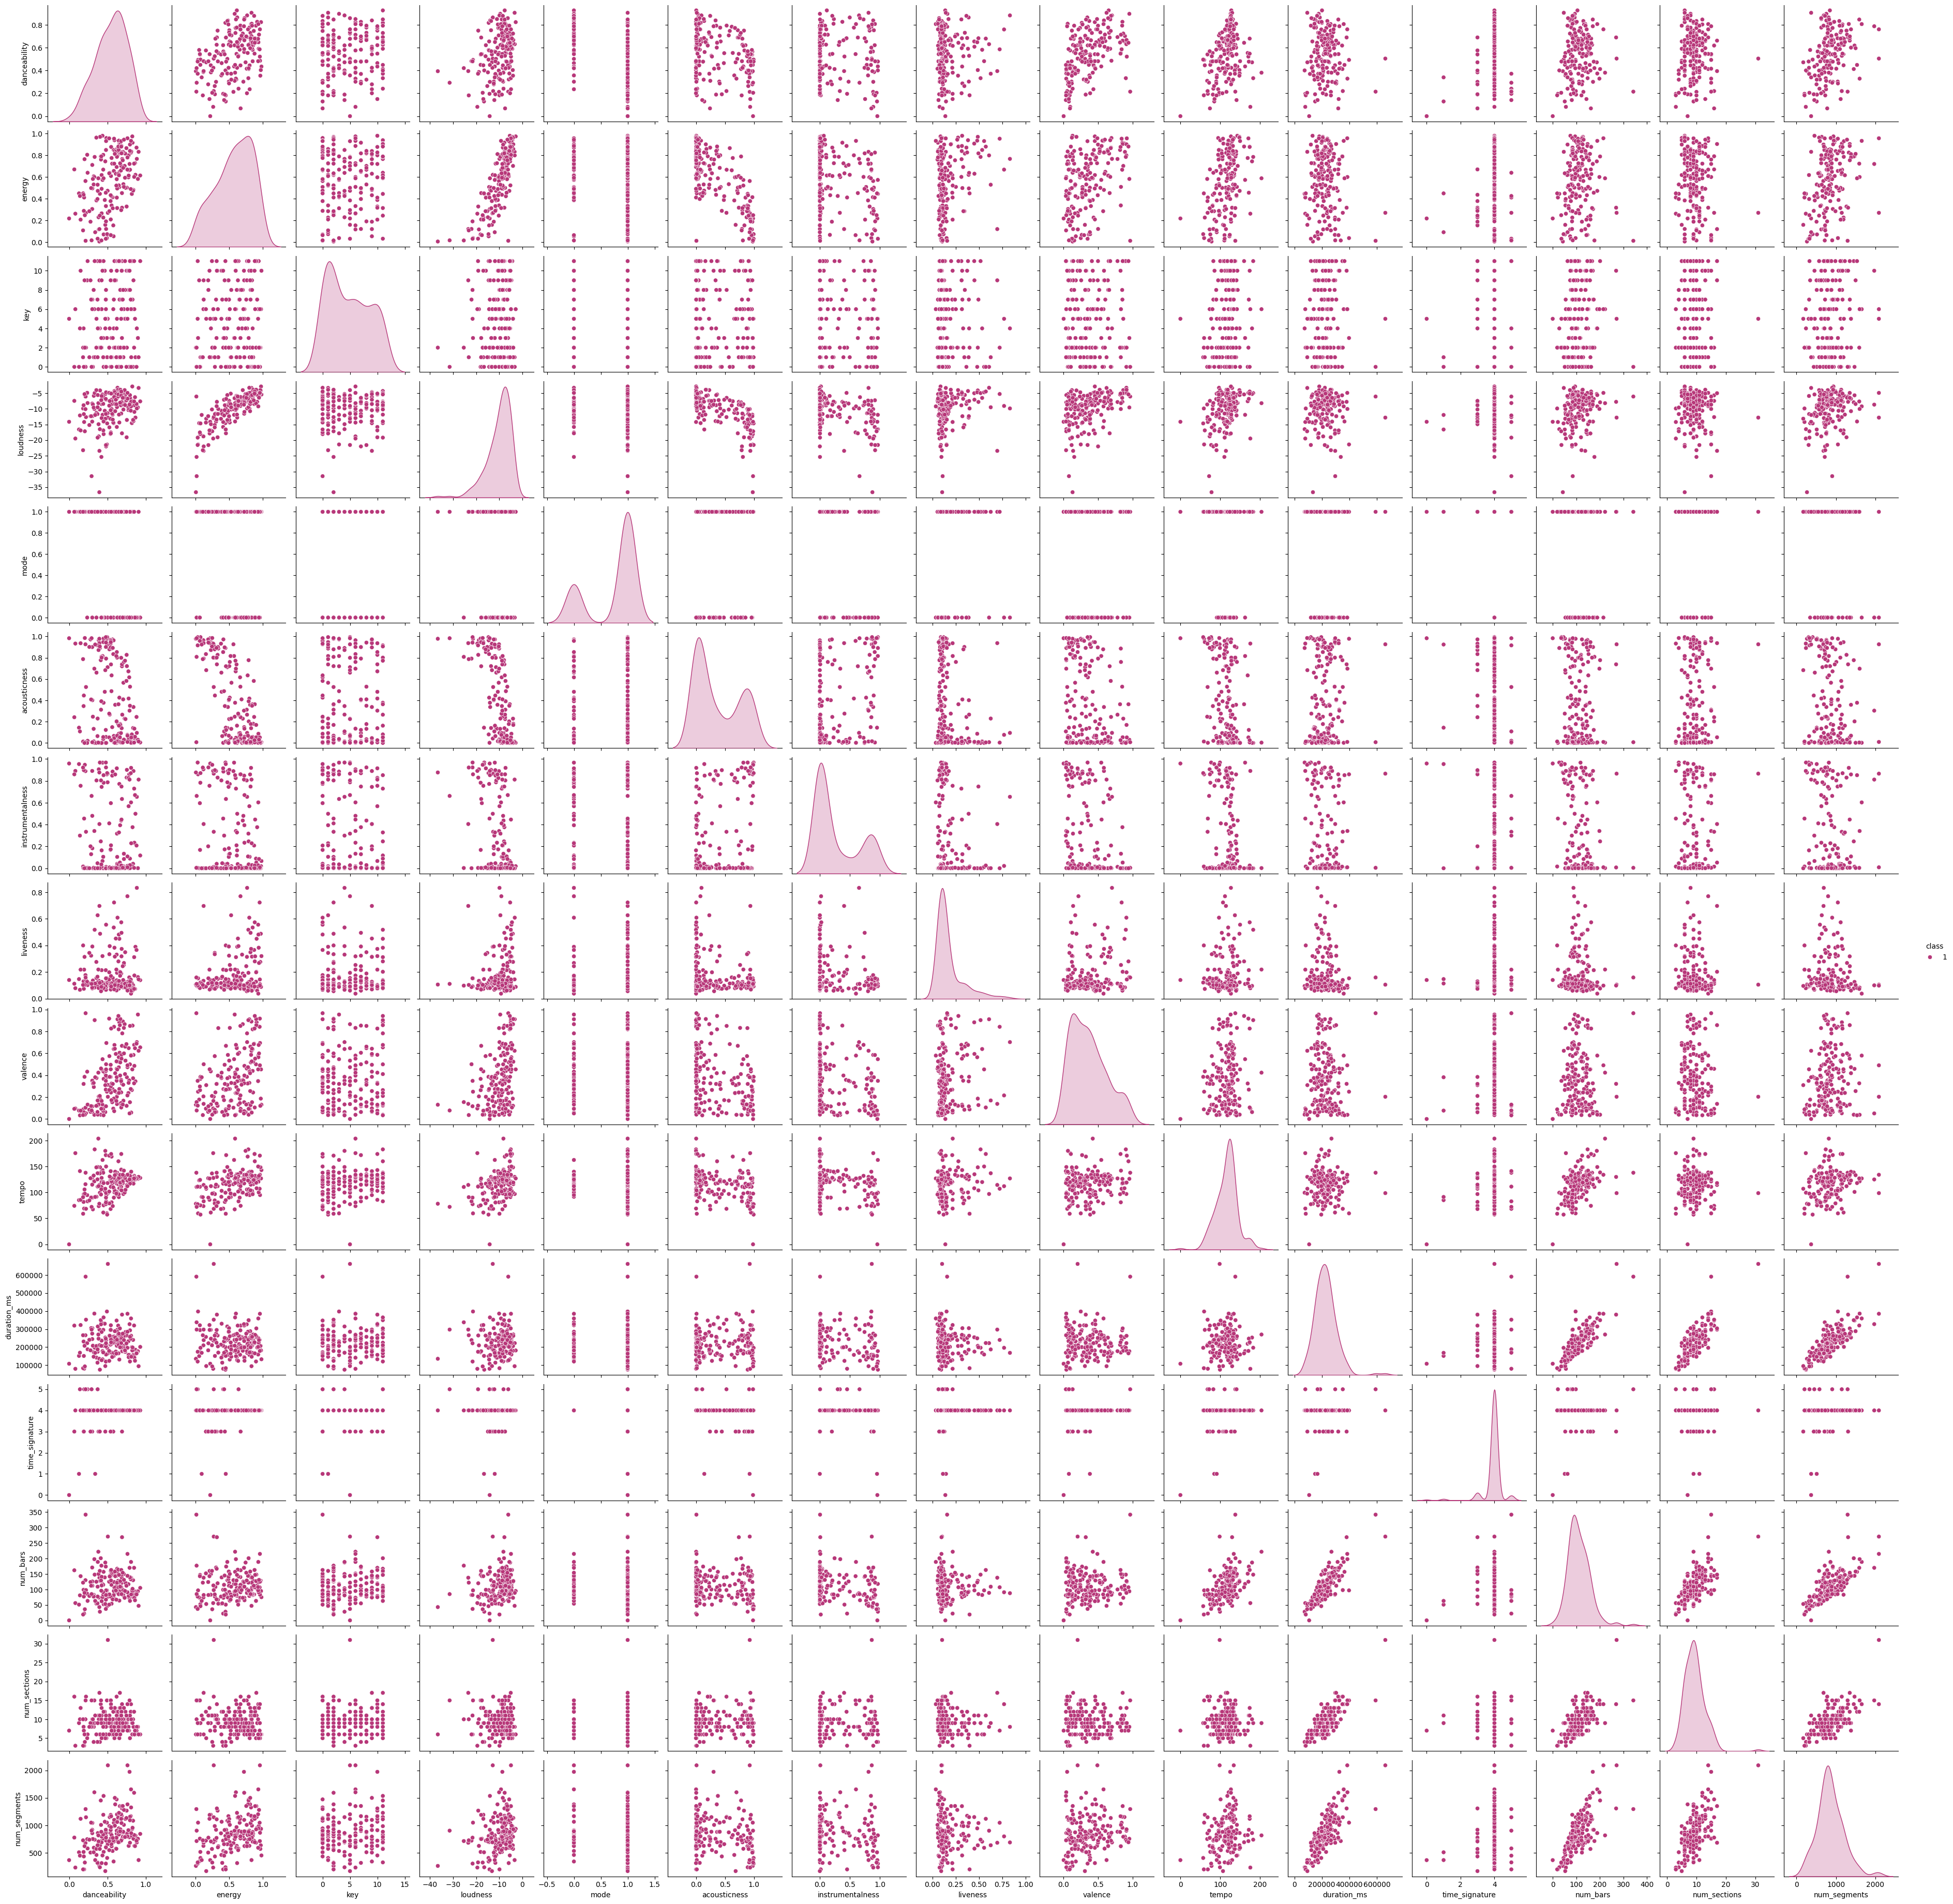

In [23]:
sns.pairplot(data=songs, hue='class', palette='magma')

#### Predicciones

In [45]:
df_list = []
for i in range(0,2):
    filename = './playlists_data/playlist_test' + str(i) + '.json'
    df_list.append(pd.read_json(filename))

songs_test = pd.concat(df_list)
songs_test = songs_test.reset_index()
songs_test = songs_test.drop_duplicates()
songs_test = songs_test.drop(['index', 'id'], axis=1)

X_train = songs.drop('class', axis=1)
X_test = songs_test.drop(['class','title'], axis=1)
y_train = songs['class']
y_test = songs_test['class']

songs_test.head()

X_train = songs.drop('class', axis=1)
X_test = songs_test.drop(['class','title'], axis=1)
y_train = songs['class']
y_test = songs_test['class']

rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

rfc_pred = rfc_model.predict(X_test)
print(confusion_matrix(y_test, rfc_pred))
print('\n')
print(classification_report(y_test, rfc_pred))
songs_test_pred = songs_test[['title','class']]
songs_test_pred.info()

songs_test_pred['pred_class'] = rfc_pred
songs_test_pred.sort_values('title')


[[51]]


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        51

    accuracy                           1.00        51
   macro avg       1.00      1.00      1.00        51
weighted avg       1.00      1.00      1.00        51

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   51 non-null     object
 1   class   51 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 948.0+ bytes


C:\Users\Yochi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
C:\Users\Yochi\AppData\Local\Temp\ipykernel_22760\4059576424.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  songs_test_pred['pred_class'] = rfc_pred


title  class  pred_class
27                                'Tis Autumn - Mono      1           1
10                                             Again      1           1
16                                             Alfie      1           1
46                                            Always      1           1
14                                   Autumn Nocturne      1           1
8                                              Belle      1           1
23                                         Blue Mood      1           1
25  Blue in Green (feat. John Coltrane & Bill Evans)      1           1
39                                               D&C      1           1
43                                         Fast Life      1           1
26                                    From The Start      1           1
49                                          Funk You      1           1
41                                               GO!      1           1
29                       He Knows She's Good For You      1           1
44                            House Music Till'Death      1           1
1                           I'm In The Mood For Love      1           1
3                                             Ithaka      1           1
18                                             Kübla      1           1
19                                         Moon Love      1           1
24                                  My Foolish Heart      1           1
33                                           Old' On      1           1
5                                         Oyster Jam      1           1
32                                         Pilsplaat      1           1
38                                        RALLY FUNK      1           1
48                                          ROCKSTAR      1           1
47                                        STASH CLUB      1           1
35                                        Shoreditch      1           1
45                                        Sofiahouse      1           1
37                                       Some Nights      1           1
34                                 Stuck In Our Ways      1           1
7                                Summer in Marseille      1           1
50                   Talk talk featuring troye sivan      1           1
4                                           Tenderly      1           1
13                               The Feeling Of Jazz      1           1
36                                              Vent      1           1
42                                     Warm The Room      1           1
2                                           We Three      1           1
15                                 While We're Young      1           1
40             Young World - Smokey Bubblin' B Remix      1           1
11                                            debris      1           1
0                                         deep in it      1           1
22                                         hot house      1           1
9                        jazz is for ordinary people      1           1
20                                  joycelyn's dance      1           1
30                                          la danse      1           1
6                                               miro      1           1
17                                       nyc in 1940      1           1
28                                               r&r      1           1
21                              show me // something      1           1
31                                 wash my sins away      1           1
12                                 wash my sins away      1           1

#### Modelos de machine learning

[[60]]


              precision    recall  f1-score   support

           1       1.00      1.00      1.00        60

    accuracy                           1.00        60
   macro avg       1.00      1.00      1.00        60
weighted avg       1.00      1.00      1.00        60



C:\Users\Yochi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


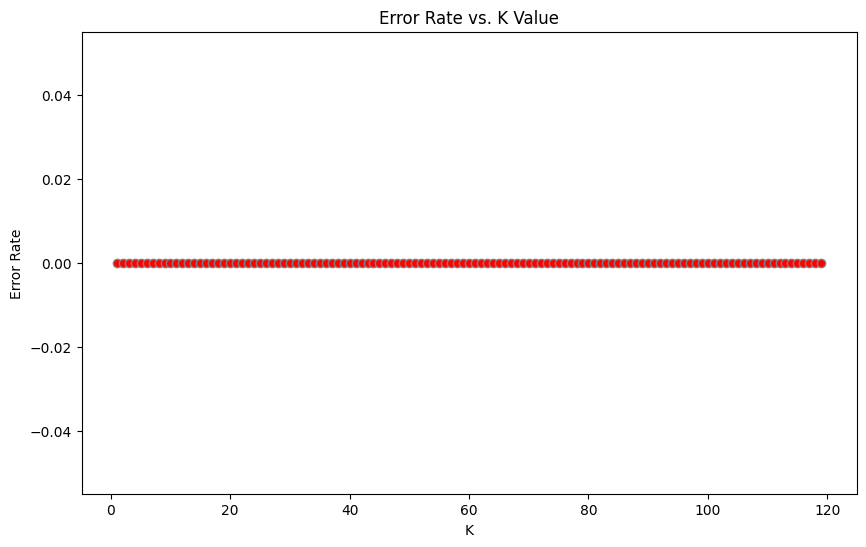

In [46]:
X = songs.drop('class', axis=1)
y = songs['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
error_rate = []

for i in range(1,120):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,120),error_rate,color='gray', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=6)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

knn_model = KNeighborsClassifier(n_neighbors=34)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
print(confusion_matrix(y_test, knn_pred))
print('\n')
print(classification_report(y_test, knn_pred))
